# PyG Static GNN Model for Engine Fault Classification

This notebook trains static Graph Neural Networks (GCN, GAT) on graph-structured data.

## 1. Setup and Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
%cd /content/drive/MyDrive/SAFRAN_ENSAI_2025_GNN_Engine/

/content/drive/MyDrive/SAFRAN_ENSAI_2025_GNN_Engine


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00


In [4]:
# Imports
import time
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
torch.manual_seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


In [21]:
# Load datasets
data_dir = Path("./results/datasets")

train_data = torch.load(data_dir / "train_pyg_static.pt", weights_only=False)
val_data = torch.load(data_dir / "val_pyg_static.pt", weights_only=False)
test_data = torch.load(data_dir / "test_pyg_static.pt", weights_only=False)

train_dataset = train_data['samples']
val_dataset = val_data['samples']
test_dataset = test_data['samples']

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nSample data object:")
print(train_dataset[0])

Train samples: 172443
Val samples: 37658
Test samples: 37658

Sample data object:
Data(x=[20, 10], edge_index=[2, 112], y=4)


In [49]:
# Configuration
BATCH_SIZE = 32 * 16
HIDDEN_DIM = 64
NUM_LAYERS = 3
NUM_CLASSES = 5
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001
DROPOUT = 0.1
MODEL_TYPE = 'GCN'  # Options: 'GCN' or 'GAT'

print(f"Configuration:")
print(f"  Model type: {MODEL_TYPE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Num classes: {NUM_CLASSES}")
print(f"  Dropout: {DROPOUT}")

Configuration:
  Model type: GCN
  Batch size: 512
  Hidden dim: 64
  Num layers: 3
  Num classes: 5
  Dropout: 0.1


In [50]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Train batches: 337
  Val batches: 74
  Test batches: 74


## 2. Model Definition

In [51]:
class StaticGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_classes, num_layers=3,
                 conv_type='GCN', dropout=0.3):
        super(StaticGNN, self).__init__()

        self.conv_type = conv_type
        self.num_layers = num_layers
        self.dropout = dropout

        # Graph convolution layers
        self.convs = nn.ModuleList()

        if conv_type == 'GCN':
            self.convs.append(GCNConv(in_channels, hidden_dim))
            for _ in range(num_layers - 1):
                self.convs.append(GCNConv(hidden_dim, hidden_dim))
        elif conv_type == 'GAT':
            heads = 4
            self.convs.append(GATConv(in_channels, hidden_dim // heads, heads=heads))
            for _ in range(num_layers - 2):
                self.convs.append(GATConv(hidden_dim, hidden_dim // heads, heads=heads))
            # Last layer: single head
            self.convs.append(GATConv(hidden_dim, hidden_dim, heads=1))
        else:
            raise ValueError(f"Unknown conv_type: {conv_type}")

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for mean+max pooling
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Graph convolutions
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1:  # No activation on last layer
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        # Global pooling: combine mean and max
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)

        # Classification
        out = self.classifier(x)
        return out

print("Model class defined.")

Model class defined.


## 3. Training and Evaluation Functions

In [52]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc='Training', leave=False)
    for data in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, data.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(data.y.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.8f}'})

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1


def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in tqdm(loader, desc='Evaluating', leave=False):
            data = data.to(device)

            logits = model(data)
            loss = criterion(logits, data.y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1, all_preds, all_labels

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 4. Training

In [55]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = train_dataset[0].x.shape[1]  # 10 timesteps

model = StaticGNN(
    in_channels=in_channels,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    conv_type=MODEL_TYPE,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Device: cpu
Model parameters: 17,605


In [ ]:
# Training loop
best_val_f1 = 0
best_val_loss = 0
patience = 20
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

start_time = time.time()

print("Starting training...")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

    epoch_time = time.time() - epoch_start

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Print progress
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.7f} | Acc: {train_acc:.7f} | F1: {train_f1:.7f}")
    print(f"  Val   Loss: {val_loss:.7f} | Acc: {val_acc:.7f} | F1: {val_f1:.7f}")
    print(f"  Epoch time: {epoch_time:.1f}s")

    # # Early stopping
    # if val_f1 > best_val_f1:
    #     best_val_f1 = val_f1
    #     patience_counter = 0
    #     torch.save(model.state_dict(), f"./results/best_pyg_static_{MODEL_TYPE.lower()}_model.pt")
    #     print(f"  ✓ Best model saved (F1: {best_val_f1:.4f})")
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print(f"\nEarly stopping at epoch {epoch+1}")
    #         break
    # Early stopping
    if val_loss > best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f"./results/best_pyg_static_{MODEL_TYPE.lower()}_model.pt")
        print(f"  ✓ Best model saved (F1: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    print("-" * 70)

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time/60:.2f} minutes")

Starting training...


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 2.1559657 | Acc: 0.3854 | F1: 0.2164
  Val   Loss: 1.5889410 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 63.6s
  ✓ Best model saved (F1: 0.1845)
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 1.6865118 | Acc: 0.3861 | F1: 0.2156
  Val   Loss: 1.5813130 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 61.2s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 1.6119862 | Acc: 0.3862 | F1: 0.2154
  Val   Loss: 1.5748723 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 62.5s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 1.5997158 | Acc: 0.3862 | F1: 0.2153
  Val   Loss: 1.5693974 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 60.4s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 1.5773246 | Acc: 0.3863 | F1: 0.2154
  Val   Loss: 1.5647983 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 59.7s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 1.5741995 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5609458 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 60.3s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 7/50
  Train Loss: 1.5565550 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5578327 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 60.8s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 8/50
  Train Loss: 1.5467050 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5553198 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 62.5s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 9/50
  Train Loss: 1.5371710 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5534520 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 61.8s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 10/50
  Train Loss: 1.5364909 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5521352 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 61.5s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 11/50
  Train Loss: 1.5322212 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5512848 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 68.7s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 12/50
  Train Loss: 1.5279186 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5508877 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 85.9s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 13/50
  Train Loss: 1.5216982 | Acc: 0.3863 | F1: 0.2153
  Val   Loss: 1.5508137 | Acc: 0.3534 | F1: 0.1845
  Epoch time: 70.7s
----------------------------------------------------------------------


Training:   0%|          | 0/337 [00:00<?, ?it/s]

## 5. Evaluation on Test Set

In [57]:
# Load best model
model.load_state_dict(torch.load(f"./results/best_pyg_static_{MODEL_TYPE.lower()}_model.pt"))

# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print("\n" + "=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("=" * 70)

Evaluating:   0%|          | 0/74 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 1.5953
Test Accuracy: 0.3898
Test F1 Score: 0.2186


In [58]:
# Classification report
label_names = ['corrosion', 'erosion', 'fouling', 'tip_clearance', 'no_fault']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_names))


Classification Report:
               precision    recall  f1-score   support

    corrosion       0.00      0.00      0.00      3770
      erosion       0.00      0.00      0.00      5515
      fouling       0.00      0.00      0.00      9440
tip_clearance       0.00      0.00      0.00      4255
     no_fault       0.39      1.00      0.56     14678

     accuracy                           0.39     37658
    macro avg       0.08      0.20      0.11     37658
 weighted avg       0.15      0.39      0.22     37658



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


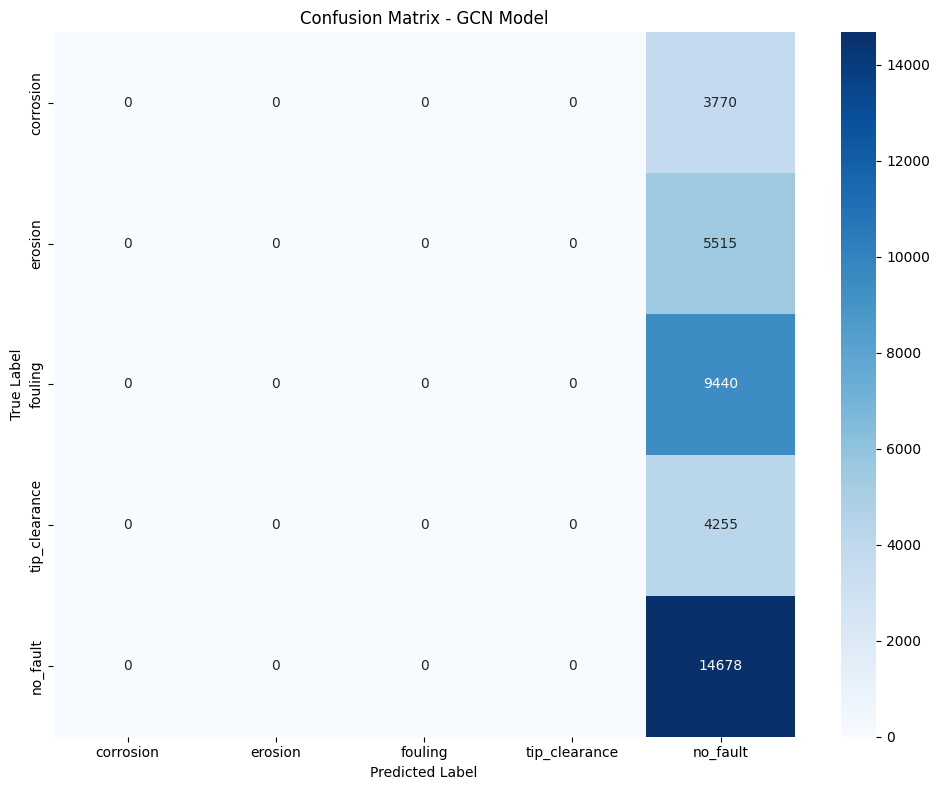

In [59]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title(f'Confusion Matrix - {MODEL_TYPE} Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'./results/confusion_matrix_pyg_static_{MODEL_TYPE.lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Training History Visualization

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy History')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(history['train_f1'], label='Train')
axes[2].plot(history['val_f1'], label='Validation')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score History')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/training_history_pyg_static_{MODEL_TYPE.lower()}.png', dpi=300, bbox_inches='tight')
plt.show()